Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
 6   sentiment  1600000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 85.4+ MB
None

Class Distribution:
0    800000
1    800000
Name: sentiment, dtype: int64


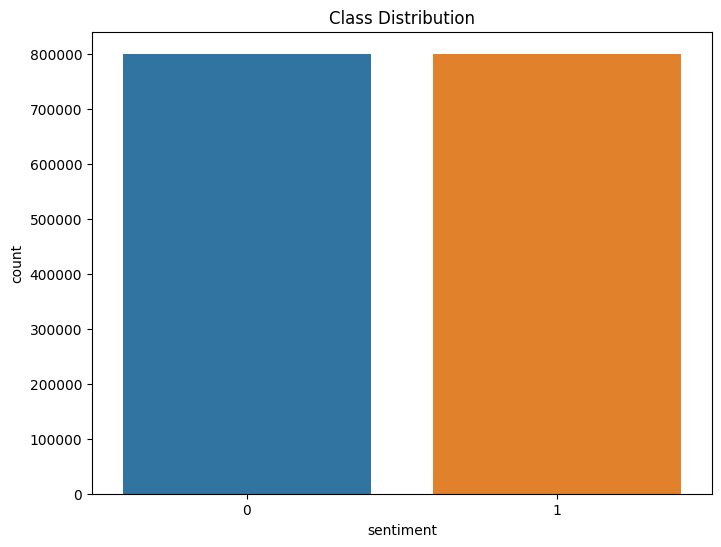


Missing Values:
target       0
ids          0
date         0
flag         0
user         0
text         0
sentiment    0
dtype: int64

Best Model Parameters:  {'multinomialnb__alpha': 1.0, 'tfidfvectorizer__max_features': 20000}
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75    159989
           1       0.76      0.74      0.75    160011

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000

Accuracy:  0.7502875


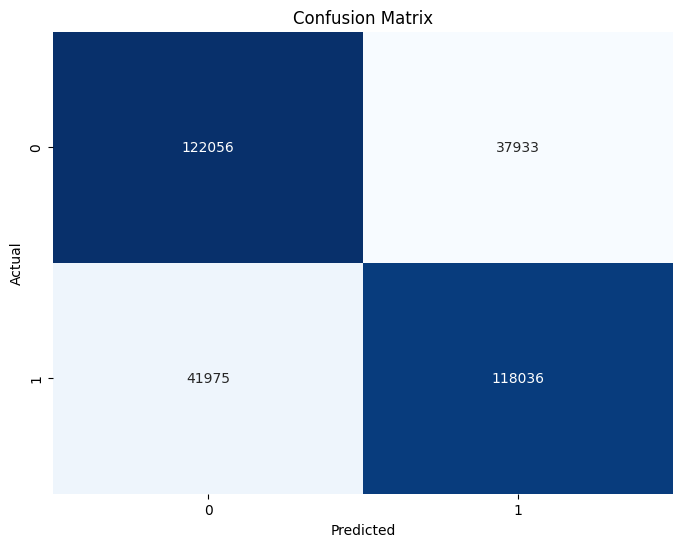

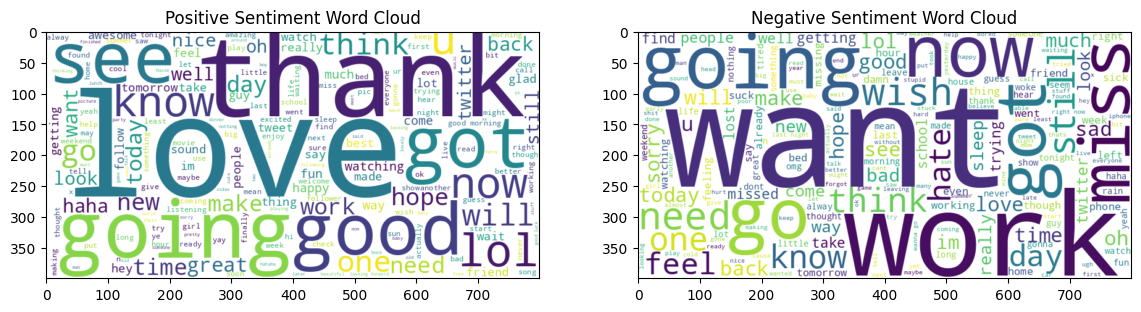

['sentiment_analysis_model.joblib']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle
from wordcloud import WordCloud

# Load the sentiment140 dataset
file_path = '/content/archive.zip'
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, header=None, names=columns, encoding='ISO-8859-1')

# Shuffle the dataset for better randomness
df = shuffle(df, random_state=42).reset_index(drop=True)

# Map sentiment labels to binary (1 for positive, 0 for non-positive)
df['sentiment'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Explore the dataset with EDA
print("Dataset Information:")
print(df.info())

print("\nClass Distribution:")
print(df['sentiment'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop unnecessary columns for the analysis
df = df[['text', 'sentiment']]

# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and extra whitespaces
    text = ' '.join([word for word in text.split() if word.isalpha()])
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])
y_train = train_df['sentiment']
y_test = test_df['sentiment']

# Create a pipeline for easier management of the workflow
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Fine-tune the model using GridSearchCV
param_grid = {
    'tfidfvectorizer__max_features': [5000, 10000, 20000],
    'multinomialnb__alpha': [0.1, 0.5, 1.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(train_df['text'], y_train)

# Use the best model from the grid search
best_model = grid.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(test_df['text'])

# Evaluate the model
print("\nBest Model Parameters: ", grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Word Cloud for positive and negative sentiments
positive_words = ' '.join(df[df['sentiment'] == 1]['text'])
negative_words = ' '.join(df[df['sentiment'] == 0]['text'])

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')

plt.show()

# Save the best model for future use
import joblib
joblib.dump(best_model, 'sentiment_analysis_model.joblib')
